# Estimación de poses con YoloV7

Es un detector de keypoints multi-persona basado en la idea de Yolo-detector. Está entrenado con Coco dataset que contiene 17 key-points. Está implementado en Pytorch y usa el modelo de detección
 **yolov7-w6-pose.pth**

<img src="https://learnopencv.com/wp-content/uploads/2022/10/coco-17-skeleton-topology.png" width="240">

<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-ms-coco-speed-ap-comparison.png" width="640">
<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-comparison.png" width="640">
<img src="https://learnopencv.com/wp-content/uploads/2022/08/yolov7-models-inference-speed-chart.png" width="640">

https://github.com/WongKinYiu/yolov7

In [ ]:
#!pip install moviepy

In [ ]:
#pip install --upgrade torchvision

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import sys
import torch
import time
import datetime

from torchvision import transforms
from PIL import Image
from moviepy.editor import *

%matplotlib inline

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



## 1. Clonando el repositorio de Yolo V7


In [2]:
YOLO_DIR = 'yolov7'

In [3]:
if not os.path.exists(YOLO_DIR):
    print("Starting to clone the YoloV7 repo\n")
    !git clone https://github.com/ivansipiran/yolov7.git
    print("\nDone")

if os.path.exists(YOLO_DIR):
    print("\nDirectory is present:\n")
    !ls yolov7

Starting to clone the YoloV7 repo

Cloning into 'yolov7'...
remote: Enumerating objects: 623, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 623 (delta 0), reused 1 (delta 0), pack-reused 622 (from 1)
Receiving objects: 100% (623/623), 42.41 MiB | 38.87 MiB/s, done.
Resolving deltas: 100% (297/297), done.

Done

Directory is present:

cfg	detect.py  hubconf.py  models	  requirements.txt  tools	  utils
data	export.py  inference   paper	  scripts	    train_aux.py
deploy	figure	   LICENSE.md  README.md  test.py	    train.py


In [4]:
RESULTS_DIR = 'results'

if not os.path.exists(RESULTS_DIR):
    print("Creating the directory:", RESULTS_DIR)
    os.mkdir(RESULTS_DIR)
    print("Done")

Creating the directory: results
Done


## 2. Modelo de YoloV7 models





Models:
https://github.com/WongKinYiu/yolov7/#performance

In [5]:
YOLOV7_MODEL = [
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt",
]

In [6]:
print("Lista de modelos de Yolo:\n")
YOLOV7_MODEL

Lista de modelos de Yolo:



['https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt']

In [7]:
def get_yolov7_model(modelistid=1):
    """
    Download YoloV7 model from a yoloV7 model list
    """
    modelid = YOLOV7_MODEL[modelistid]

    if not os.path.exists(modelid):
        print("Downloading the model:",
              os.path.basename(modelid), "from:", modelid)
        urllib.request.urlretrieve(modelid,
                                   filename=os.path.basename(modelid))
        print("Done\n")
        !ls yolo*.pt -lh

    if os.path.exists(modelid):
        print("Downloaded model files:")
        !ls yolo*.pt -lh

## 3. YoloV7 sobre imagenes

In [8]:
!pip install gdown

#Descargamos datos para probar
import gdown

id = '1JB0f2QYenzSNeoxlrybXsh6msZybOLlJ'
output='data.zip'
gdown.download(id=id, output=output, quiet=False)

!unzip data.zip


Downloading...
From: https://drive.google.com/uc?id=1JB0f2QYenzSNeoxlrybXsh6msZybOLlJ
To: /content/data.zip
100%|██████████| 2.81M/2.81M [00:00<00:00, 191MB/s]

Archive:  data.zip
   creating: data/
  inflating: data/football.jpg       
  inflating: data/football.mp4       
  inflating: data/tennis.mp4         
  inflating: data/sport.mp4          


# Cambiar al directorio Yolov7, en adelante trabajamos sobre ese directorio


In [9]:
os.chdir(YOLO_DIR)

In [10]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def image_view(imagefile, w=15, h=10):
    """
    Displaying an image from an image file
    """
    %matplotlib inline
    plt.figure(figsize=(w, h))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread(imagefile),
                            cv2.COLOR_BGR2RGB))

In [13]:
print(device)

cuda:0


# Cargando y optimizando algunos aspectos del modelo para obtener la inferencia

In [14]:
def loading_yolov7_model(yolomodel):
    """
    Loading yolov7 model
    """
    print("Loading model:", yolomodel)
    # load the model to GPU
    model = torch.load(yolomodel, map_location=device,weights_only=False)['model']
    #loading the weights from the yolo model because only use the model inference
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)

    return model, yolomodel

In [15]:
def running_inference(image):
    """
    Running yolov7 model inference
    """
    # image pre-processing (scaleing to the high component)
    image = letterbox(image, 960,
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960]) Ch,W,H

    if torch.cuda.is_available():
        image = image.half().to(device)
    # preparing the tensor to using data batches
    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    # we dont'need calcule gradients because it's part of the train step
    with torch.no_grad():
        output, _ = model(image)

    return output, image

In [16]:
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

    # Return the image WxHxCh in 255-scale, 8bits
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    return nimg

### 3.1 Usando Tiny Yolov7


In [17]:
YOLOV7_MODEL[0]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt'

In [18]:
get_yolov7_model(0)

Done

-rw-r--r-- 1 root root 13M Oct 24 18:19 yolov7-tiny.pt


In [19]:

#YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[0])
YOLOV7MODEL='/content/yolov7/yolov7-tiny.pt'
print(YOLOV7MODEL)
#try:
print("Loading the model...")
model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
print("Using the", YOLOV7MODEL, "model")
print("Done")

#except:
 #   print("[Error] Cannot load the model", YOLOV7MODEL)

/content/yolov7/yolov7-tiny.pt
Loading the model...
Loading model: /content/yolov7/yolov7-tiny.pt
Using the /content/yolov7/yolov7-tiny.pt model
Done


In [ ]:
#!pwd
%ls /content/yolov7

cfg/       export.py   LICENSE.md  requirements.txt  train_aux.py
data/      figure/     models/     scripts/          train.py
deploy/    hubconf.py  paper/      test.py           utils/
detect.py  inference/  README.md   tools/            yolov7-tiny.pt


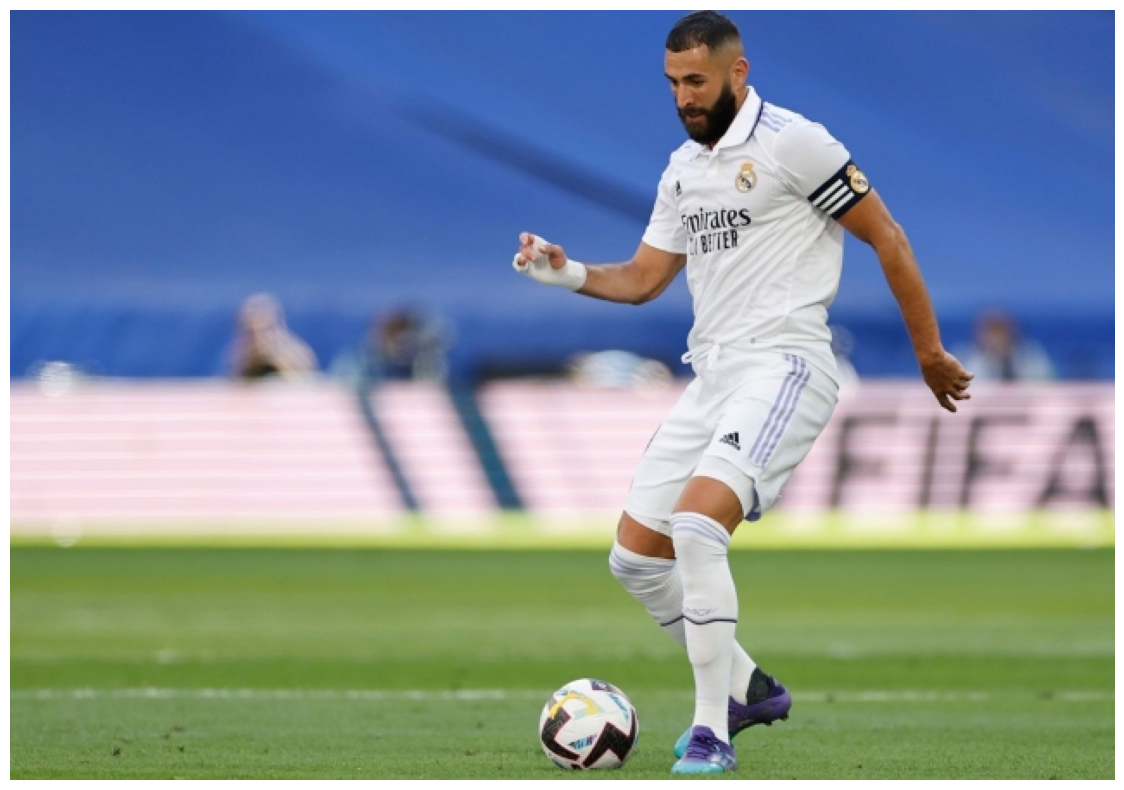

In [20]:
image_view("../data/football.jpg")

In [21]:
!python detect.py --weights ./yolov7-tiny.pt --conf 0.2 --img-size 640 --source ../data/football.jpg

Namespace(weights=['./yolov7-tiny.pt'], source='../data/football.jpg', img_size=640, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 b12a880 torch 2.8.0+cu126 CUDA:0 (Tesla T4, 15095.0625MB)

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
4 persons, 1 sports ball, Done. (5.2ms) Inference, (179.7ms) NMS
 The image with the result is saved in: runs/detect/exp/footba

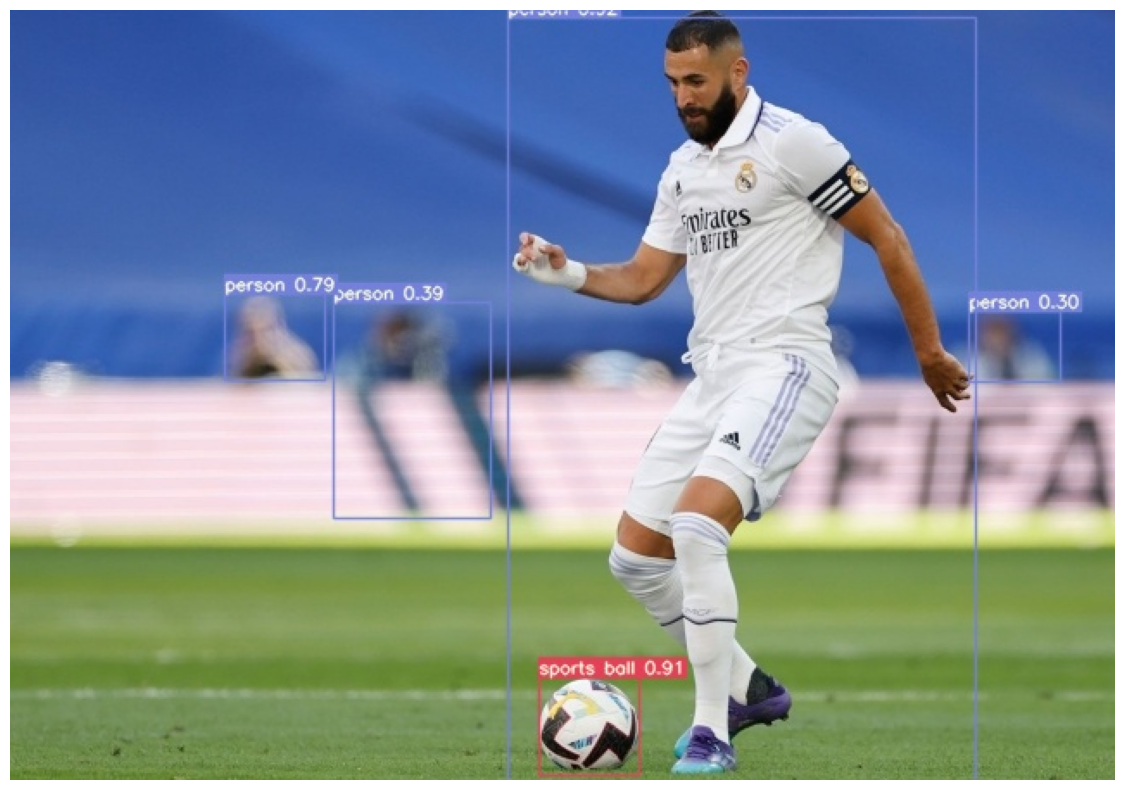

In [22]:
image_view("runs/detect/exp/football.jpg")

### 3.2 Usando el modelo yolov7-w6-pose

In [23]:
YOLOV7_MODEL[7]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt'

In [24]:
get_yolov7_model(7)

Done

-rw-r--r-- 1 root root  13M Oct 24 18:19 yolov7-tiny.pt
-rw-r--r-- 1 root root 154M Oct 24 18:24 yolov7-w6-pose.pt


In [25]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[7])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-w6-pose.pt
Using the yolov7-w6-pose.pt model
Done


  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



torch.Size([1, 42075, 57])


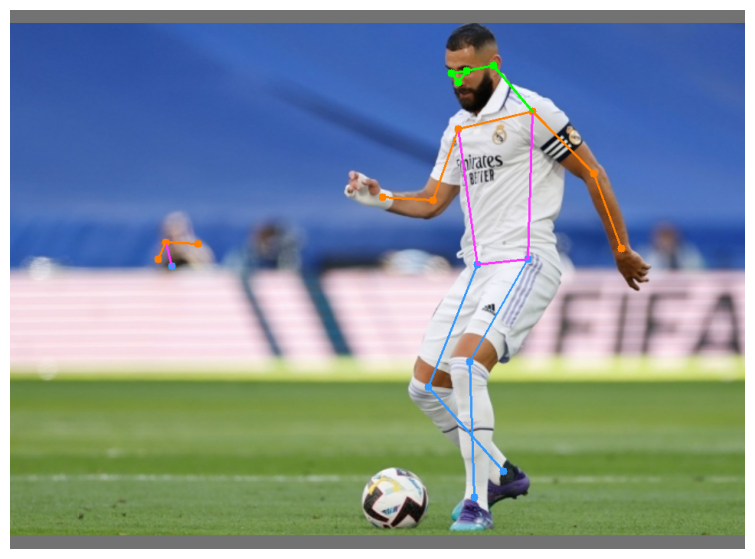

In [26]:
imagefile = "../data/football.jpg"

output, image = running_inference(cv2.imread(imagefile))
pose_image = draw_keypoints(output, image, confidence=0.25, threshold=0.65)
print(output.shape)

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)

## 4. Analysing a video with yolov7-w6-pose

In [27]:
def yoloV7_pose_video(videofile, confidence=0.25, threshold=0.65):
    """
    Processing the video using YoloV7
    """
    start = time.time()
    # Reading video
    video = VideoFileClip(videofile)

    # Stats
    duration = video.duration
    fps = round(video.fps)
    nbframes = round(duration * fps)

    print("Processing video:", videofile, "using confidence min =", confidence,
          "and threshold =", threshold)
    print("\nVideo duration =", duration, "seconds")
    print("FPS =", fps)
    print("Total number of frames =", nbframes, "\n")

    # Capture the results frames into a video
    capture = cv2.VideoCapture(videofile)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outputvideofile = "../results/result_" + os.path.basename(videofile)
    outvideo = cv2.VideoWriter(outputvideofile, fourcc, 30.0,
                               (int(capture.get(3)), int(capture.get(4))))
    idx = 1

    while capture.isOpened():
        (ret, frame) = capture.read()

        if ret == True:
            if idx % fps == 1:
                nbremainframes = nbframes - idx
                pctdone = round(idx / nbframes * 100)
                print("Processed frames =", f"{idx:06}",
                      "| Number of remaining frames:", f"{nbremainframes:06}",
                      "| Done:", pctdone, "%")

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = running_inference(frame)
            frame = draw_keypoints(output, frame, confidence, threshold)
            frame = cv2.resize(frame,
                               (int(capture.get(3)), int(capture.get(4))))

            cv2.imwrite(
                "results/videoframe_" + os.path.basename(videofile) + '_' +
                str(f"{idx:06}.jpg"), frame)
            outvideo.write(frame)  # output to video file

        else:
            break

        idx += 1

    processed_time = round(time.time() - start)
    time_per_frame = round(processed_time / (idx - 1), 2)
    print("\nDone in", processed_time, "seconds")
    print("Time per frame =", time_per_frame, "seconds")
    print("\nSaved video:", outputvideofile)

    capture.release()
    outvideo.release()

    return outputvideofile

### 4.1 Test 1

In [28]:
!ls ../data/football.mp4 -lh

-rw-rw-r-- 1 root root 897K Dec 11  2024 ../data/football.mp4


In [29]:
football_vid = "../data/football.mp4"
football_video = yoloV7_pose_video(football_vid)

Processing video: ../data/football.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 13.1 seconds
FPS = 10
Total number of frames = 131 

Processed frames = 000001 | Number of remaining frames: 000130 | Done: 1 %
Processed frames = 000011 | Number of remaining frames: 000120 | Done: 8 %
Processed frames = 000021 | Number of remaining frames: 000110 | Done: 16 %
Processed frames = 000031 | Number of remaining frames: 000100 | Done: 24 %
Processed frames = 000041 | Number of remaining frames: 000090 | Done: 31 %
Processed frames = 000051 | Number of remaining frames: 000080 | Done: 39 %
Processed frames = 000061 | Number of remaining frames: 000070 | Done: 47 %
Processed frames = 000071 | Number of remaining frames: 000060 | Done: 54 %
Processed frames = 000081 | Number of remaining frames: 000050 | Done: 62 %
Processed frames = 000091 | Number of remaining frames: 000040 | Done: 69 %
Processed frames = 000101 | Number of remaining frames: 000030 | Done: 77 %
Process

In [30]:
VideoFileClip(football_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  71%|███████   | 94/132 [00:00<00:00, 409.76it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ../results/result_football.mp4, 587520 bytes wanted but 0 bytes read,at frame 131/132, at time 4.37/4.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 4.2 Test 2

In [31]:
!ls ../data/tennis.mp4 -lh

-rw-rw-r-- 1 root root 779K Dec 11  2024 ../data/tennis.mp4


In [32]:
tennis_vid = "../data/tennis.mp4"
tennis_video = yoloV7_pose_video(tennis_vid)

Processing video: ../data/tennis.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 14.6 seconds
FPS = 25
Total number of frames = 365 

Processed frames = 000001 | Number of remaining frames: 000364 | Done: 0 %
Processed frames = 000026 | Number of remaining frames: 000339 | Done: 7 %
Processed frames = 000051 | Number of remaining frames: 000314 | Done: 14 %
Processed frames = 000076 | Number of remaining frames: 000289 | Done: 21 %
Processed frames = 000101 | Number of remaining frames: 000264 | Done: 28 %
Processed frames = 000126 | Number of remaining frames: 000239 | Done: 35 %
Processed frames = 000151 | Number of remaining frames: 000214 | Done: 41 %
Processed frames = 000176 | Number of remaining frames: 000189 | Done: 48 %
Processed frames = 000201 | Number of remaining frames: 000164 | Done: 55 %
Processed frames = 000226 | Number of remaining frames: 000139 | Done: 62 %
Processed frames = 000251 | Number of remaining frames: 000114 | Done: 69 %
Processed

In [33]:
VideoFileClip(tennis_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  97%|█████████▋| 355/366 [00:01<00:00, 246.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ../results/result_tennis.mp4, 691200 bytes wanted but 0 bytes read,at frame 365/366, at time 12.17/12.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 4.3 Test 3

In [34]:
!ls ../data/sport.mp4 -lh

-rw-rw-r-- 1 root root 883K Dec 11  2024 ../data/sport.mp4


In [35]:
sport_vid = "../data/sport.mp4"
sport_video = yoloV7_pose_video(sport_vid)

Processing video: ../data/sport.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 23.52 seconds
FPS = 10
Total number of frames = 235 

Processed frames = 000001 | Number of remaining frames: 000234 | Done: 0 %
Processed frames = 000011 | Number of remaining frames: 000224 | Done: 5 %
Processed frames = 000021 | Number of remaining frames: 000214 | Done: 9 %
Processed frames = 000031 | Number of remaining frames: 000204 | Done: 13 %
Processed frames = 000041 | Number of remaining frames: 000194 | Done: 17 %
Processed frames = 000051 | Number of remaining frames: 000184 | Done: 22 %
Processed frames = 000061 | Number of remaining frames: 000174 | Done: 26 %
Processed frames = 000071 | Number of remaining frames: 000164 | Done: 30 %
Processed frames = 000081 | Number of remaining frames: 000154 | Done: 34 %
Processed frames = 000091 | Number of remaining frames: 000144 | Done: 39 %
Processed frames = 000101 | Number of remaining frames: 000134 | Done: 43 %
Processed 

In [36]:
VideoFileClip(sport_video).ipython_display(width=640)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
